In [1]:
import adlfs
import xarray as xr

import xarray as xr

import numpy as np

from matplotlib import pyplot as plt

from cartopy import crs as ccrs
import cartopy.feature as cfeature

import datetime

from pathlib import Path

import warnings
import pathlib
warnings.filterwarnings('ignore')
import tempfile

# VIIRS Fire Detection

This example uses data from JPSS. We'll follow the examples from https://github.com/modern-tools-workshop/AMS-python-workshop-2023/ by Drs. Rebekah Esmaili and Amy Huff, for finding some interesting files and loading them up.

## Finding files

The files are in the `jpss` Storage Account, and the `noaa-20`, `noaa-21` and `snpp` storage containers.

The files are not yet cataloged with STAC, and so we have to manually list the files.

In [2]:
fs = adlfs.AzureBlobFileSystem("jpss", anon=True)

files = fs.ls("noaa-20/VIIRS-AF-Iband-EDR/2022/10/16/")
print(len(files), "files")

1011 files


Of the files on that day, we'll select out a few from the time we care about:

In [3]:
start_time = '2116'
end_time = '2119'

matches = [file for file in files if (file.split('/')[-1].split('_')[3][9:13] >= start_time and file.split('/')[-1].split('_')[3][9:13] <= end_time)]

for match in matches:
    print(match.split('/')[-1])
    print('Approximate file size (MB):', round((fs.size(match)/1.0E6), 2))

AF-Iband_v1r0_j01_s202210162116424_e202210162118070_c202210162142397.nc
Approximate file size (MB): 0.78
AF-Iband_v1r0_j01_s202210162118082_e202210162119327_c202210162142235.nc
Approximate file size (MB): 0.96
AF-Iband_v1r0_j01_s202210162119340_e202210162120567_c202210162143123.nc
Approximate file size (MB): 0.83


In [4]:
f = matches[1]

These files use "groups" to organize data within the file. We'll load the "Fire Pixels" group.

In [5]:
ds_group = xr.open_dataset(fs.open(f), engine="h5netcdf", group="Fire Pixels").load()

ds_group

<xarray.Dataset>
Dimensions:                       (nfire: 161)
Dimensions without coordinates: nfire
Data variables: (12/25)
    FP_line                       (nfire) uint16 278 293 807 ... 1490 1491 1509
    FP_sample                     (nfire) uint16 480 478 2284 ... 1574 1574 1011
    FP_latitude                   (nfire) float32 42.68 42.68 ... 46.34 46.56
    FP_longitude                  (nfire) float32 -111.6 -111.6 ... -115.0
    FP_T4                         (nfire) float32 348.1 330.0 ... 340.8 331.1
    FP_T5                         (nfire) float32 296.7 294.4 ... 301.5 295.0
    ...                            ...
    FP_day                        (nfire) uint8 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    FP_SolZenAng                  (nfire) float32 59.3 59.31 ... 59.84 61.21
    FP_SolAzAng                   (nfire) float32 -143.0 -143.0 ... -147.5
    FP_ViewZenAng                 (nfire) float32 62.72 62.74 ... 45.99 55.94
    FP_ViewAzAng                  (nfire) float32 -92.12 -91.56 ... -93.07
    FP_PersistentAnomalyCategory  (nfire) uint8 5 5 0 0 0 0 0 ... 0 0 0 0 0 0 0

You can click the disclosure trinagles to expand the information about each data variable. In this case, there are 161 fire pixels. We'll plot the latitude and longitude for each.

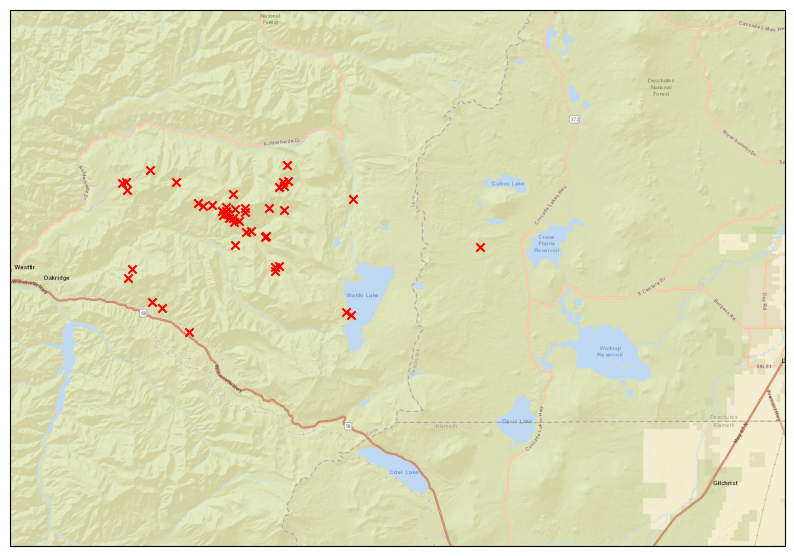

In [6]:
import cartopy.io.img_tiles

esri_tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Street_Map/MapServer/tile/{z}/{y}/{x}.jpg'
map_background = cartopy.io.img_tiles.GoogleTiles(url=esri_tiles)

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=map_background.crs)

zoom_level = 11

ax.add_image(map_background, zoom_level)

ds_group.plot.scatter(x="FP_longitude", y="FP_latitude", ax=ax, color="red", marker="x", transform=ccrs.PlateCarree())

ax.set_extent([-122.5, -121.5, 43.5, 44.0], crs=ccrs.PlateCarree())
plt.show()

## Overlaying Imagery

The NetCDF file from JPSS has some global attributes describing its spatio-temporal extent. We can feed that data to the Planetary Computer's STAC API to combine the fire detection data with visual imagery.

In [13]:
import shapely
import pystac_client
import planetary_computer
import dateutil.parser
import datetime

In [14]:
attrs = xr.open_dataset(fs.open(f), engine="h5netcdf").attrs
start_datetime = dateutil.parser.parse(attrs["time_coverage_start"]) - datetime.timedelta(days=3)
end_datetime = dateutil.parser.parse(attrs["time_coverage_end"]) + datetime.timedelta(days=3)

geometry = shapely.from_wkt(attrs["geospatial_bounds"])
print(start_datetime, end_datetime)

2022-10-13 21:18:08.300000+00:00 2022-10-19 21:19:32.800000+00:00


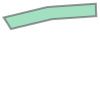

In [15]:
geometry

In [16]:
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=planetary_computer.sign_inplace)

In [17]:
items = catalog.search(collections="sentinel-2-l2a", bbox=[-122.5, 43.5, -121.5, 44.0], datetime=[start_datetime, end_datetime]).item_collection()

len(items)

6

In [19]:
import ipyleaflet
import ipywidgets
import pystac
import requests

In [28]:
m = ipyleaflet.Map(zoom=8)
m.layout.width = "600px"

@ipywidgets.interact(item = items)
def browse(item: pystac.Item):
    shape = shapely.geometry.shape(item.geometry)
    m.center = tuple(shape.centroid.coords[0])[::-1]

    for layer in m.layers:
        if isinstance(layer, ipyleaflet.TileLayer) and not layer.attribution:
            m.remove(layer)
    m.add(
        ipyleaflet.TileLayer(url=requests.get(item.assets["tilejson"].href).json()["tiles"][0])
    )
    print(item.id, item.datetime.isoformat())

m

interactive(children=(Dropdown(description='item', options=(<Item id=S2B_MSIL2A_20221019T190419_R013_T10TFP_20…

Map(center=[43.759302419446264, -121.11184210543124], controls=(ZoomControl(options=['position', 'zoom_in_text…

This is a very rough version of the Planetary Computer's [Explorer](https://planetarycomputer.microsoft.com/explore?c=-123.2774%2C44.4188&z=10.15&v=2&d=sentinel-2-l2a&s=false%3A%3A100%3A%3Atrue&ae=0&sr=desc&m=cql%3Ad270f5a3f7cb3f75b8c84abefe61d74c&r=Natural+color).